In [1]:
import numpy as np
import copy
import time
import matplotlib.pyplot as plt
import open3d as o3d
import utm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
##PLY TO PCD
# source_to_pcd = o3d.io.read_point_cloud("/home/turin/Desktop/lizard_dataset_curated/old_dataset_coral/cur_cas_05m_20190401_dec7M.ply")
# o3d.io.write_point_cloud("/home/turin/Desktop/lizard_dataset_curated/source.pcd", source_to_pcd)
pcd_14 = o3d.io.read_point_cloud("/home/turin/Desktop/lizard_dataset_curated/2014/pcd14.pcd")
pcd_15 = o3d.io.read_point_cloud("/home/turin/Desktop/lizard_dataset_curated/2015/pcd15.pcd")
pcd_16 = o3d.io.read_point_cloud("/home/turin/Desktop/lizard_dataset_curated/2016/pcd16.pcd")
pcd_14_cp = copy.deepcopy(pcd_14)
pcd_15_cp = copy.deepcopy(pcd_15)
pcd_16_cp = copy.deepcopy(pcd_16)

42312642


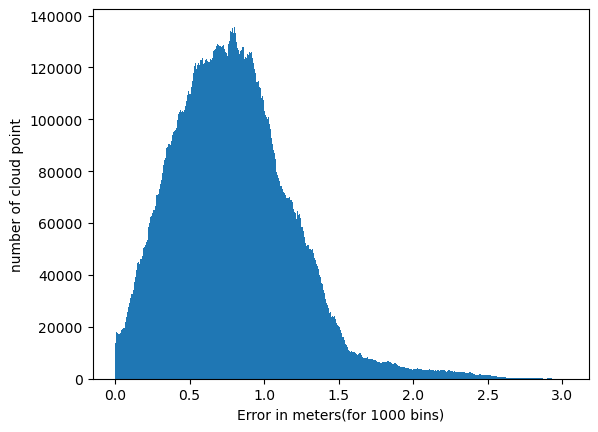

In [5]:
dist_error = pcd_15_cp.compute_point_cloud_distance(pcd_14_cp)
error_fast = []
for x in range(len(dist_error)):
    error_fast.append(dist_error[x])
print(len(error_fast))
_ = plt.hist(error_fast, bins=1000)
plt.xlabel("Error in meters(for 1000 bins)")
plt.ylabel("number of cloud point")
plt.show()

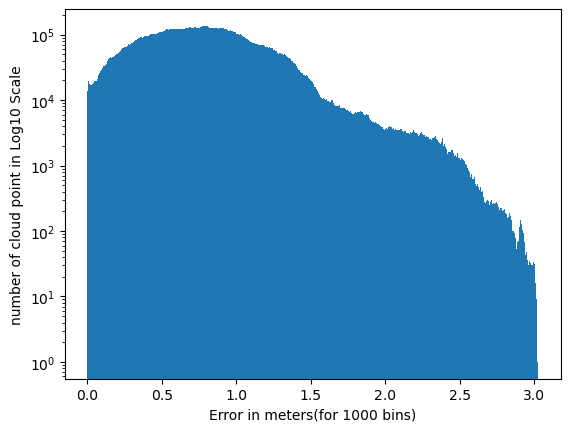

In [6]:
_ = plt.hist(error_fast, bins=1000)
plt.xlabel("Error in meters(for 1000 bins)")
plt.ylabel("number of cloud point in Log10 Scale")
plt.yscale("log")
plt.show()

In [7]:
error_init = error_fast
max(error_init), min(error_init),sum(error_init)/len(error_init)

(3.0253827921808703, 7.327794155997675e-05, 0.792815817385412)

In [3]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 3
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

def prepare_dataset(source, target, voxel_size):
    print(":: Load two point clouds with initial pose.")
    # trans_init = np.asarray([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0],
    #                          [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
    # source.transform(trans_init)
    draw_registration_result(source, target, np.identity(4))

    source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
    return source, target, source_down, target_down, source_fpfh, target_fpfh

def execute_fast_global_registration(source_down, target_down, source_fpfh,
                                     target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    print(":: Apply fast global registration with distance threshold %.3f" \
            % distance_threshold)
    result = o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh,
        o3d.pipelines.registration.FastGlobalRegistrationOption(
            maximum_correspondence_distance=distance_threshold))
    return result

In [4]:
#FAST GLOBAL TRANSFORMATION
start = time.time()
voxel_size = 0.1  # 0.05 means 5cm for this dataset
source, target, source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(pcd_15_cp, pcd_14_cp,
    voxel_size)

result_fast = execute_fast_global_registration(source_down, target_down,
                                               source_fpfh, target_fpfh,
                                               voxel_size)
print("Fast global registration took %.3f sec.\n" % (time.time() - start))
print(result_fast)
result_fast.transformation
draw_registration_result(source, target, result_fast.transformation)

:: Load two point clouds with initial pose.
:: Downsample with a voxel size 0.100.
:: Estimate normal with search radius 0.200.
:: Compute FPFH feature with search radius 0.300.
:: Downsample with a voxel size 0.100.
:: Estimate normal with search radius 0.200.
:: Compute FPFH feature with search radius 0.300.
:: Apply fast global registration with distance threshold 0.150
Fast global registration took 64.467 sec.

RegistrationResult with fitness=7.218358e-01, inlier_rmse=8.219473e-02, and correspondence_set size of 41821
Access transformation to get result.


In [5]:
source_fast = copy.deepcopy(source).transform(result_fast.transformation)
dif = target.compute_point_cloud_distance(source_fast)

In [6]:
error_fast = []
for x in range(len(dif)):
    error_fast.append(dif[x])
print(len(error_fast))

39712538


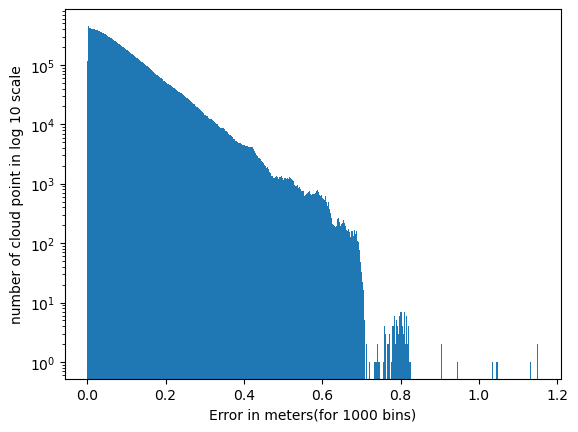

In [14]:
_ = plt.hist(error_fast, bins=1000)
plt.xlabel("Error in meters(for 1000 bins)")
plt.ylabel("number of cloud point in log 10 scale")
plt.yscale("log")
plt.show()

In [16]:
_[0]

array([1.15411e+05, 4.39900e+05, 4.54185e+05, 4.34341e+05, 4.25883e+05,
       4.21056e+05, 4.17074e+05, 4.15246e+05, 4.12345e+05, 4.10108e+05,
       4.08681e+05, 4.07173e+05, 4.05346e+05, 4.06900e+05, 4.03619e+05,
       4.02326e+05, 3.98832e+05, 3.96760e+05, 3.93898e+05, 3.92188e+05,
       3.88851e+05, 3.86314e+05, 3.83556e+05, 3.80724e+05, 3.78938e+05,
       3.75850e+05, 3.73942e+05, 3.69857e+05, 3.66131e+05, 3.63656e+05,
       3.60773e+05, 3.58008e+05, 3.54468e+05, 3.51353e+05, 3.47330e+05,
       3.44049e+05, 3.41676e+05, 3.37658e+05, 3.33570e+05, 3.28946e+05,
       3.26146e+05, 3.22513e+05, 3.18258e+05, 3.15243e+05, 3.11587e+05,
       3.06709e+05, 3.03202e+05, 2.99677e+05, 2.96463e+05, 2.93079e+05,
       2.90282e+05, 2.87365e+05, 2.83240e+05, 2.79386e+05, 2.75805e+05,
       2.73087e+05, 2.68692e+05, 2.65614e+05, 2.62934e+05, 2.59909e+05,
       2.57873e+05, 2.53878e+05, 2.50855e+05, 2.48617e+05, 2.44622e+05,
       2.42172e+05, 2.38591e+05, 2.35190e+05, 2.32331e+05, 2.293

In [13]:
min(error_fast), max(error_fast), sum(error_fast)/len(error_fast)

(2.069460007542929e-05, 1.1512259471841428, 0.08756122041059382)

In [9]:
#Registration ICP
treg = o3d.pipelines.registration
max_correspondence_distance = 0.05
trans_init = np.asarray(result_fast.transformation, dtype=np.float64)
#mu, sigma = 0, 0.1  # mean and standard deviation
loss = o3d.pipelines.registration.TukeyLoss(0.1)
estimation = treg.TransformationEstimationPointToPlane(loss)
# Convergence-Criteria for Vanilla ICP
criteria = treg.ICPConvergenceCriteria(relative_fitness=0.0000001,
                                       relative_rmse=0.000001,
                                       max_iteration=50)
# Save iteration wise `fitness`, `inlier_rmse`, etc. to analyse and tune result.
save_loss_log = True
registration_icp = treg.registration_icp(source, target, max_correspondence_distance,
                            trans_init, estimation, criteria)

print("Inlier Fitness: ", registration_icp.fitness)
print("Inlier RMSE: ", registration_icp.inlier_rmse)

draw_registration_result(source, target, registration_icp.transformation)

Inlier Fitness:  0.3919485339629702
Inlier RMSE:  0.027669973409542702


In [18]:
source = o3d.t.io.read_point_cloud("/home/turin/Desktop/lizard_dataset_curated/2014/pcd14.pcd")
target = o3d.t.io.read_point_cloud("/home/turin/Desktop/lizard_dataset_curated/2015/pcd15.pcd")

In [ ]:
init_trans = o3d.core.Tensor(result_fast.transformation)
print(init_trans)

In [ ]:
treg = o3d.t.pipelines.registration
voxel_sizes = o3d.utility.DoubleVector([0.1, 0.05, 0.03])
criteria_list = [
    treg.ICPConvergenceCriteria(relative_fitness=0.000001,
                                relative_rmse=0.000001,
                                max_iteration=200),
    treg.ICPConvergenceCriteria(0.0000001, 0.0000001, 50),
    treg.ICPConvergenceCriteria(0.00000001, 0.00000001, 25)
]
max_correspondence_distances = o3d.utility.DoubleVector([.7, 0.7, 0.7])
estimation = treg.TransformationEstimationPointToPlane()

# Save iteration wise `fitness`, `inlier_rmse`, etc. to analyse and tune result.
callback_after_iteration = lambda loss_log_map : print("Iteration Index: {}, Scale Index: {}, Scale Iteration Index: {}, Fitness: {}, Inlier RMSE: {},".format(
    loss_log_map["iteration_index"].item(),
    loss_log_map["scale_index"].item(),
    loss_log_map["scale_iteration_index"].item(),
    loss_log_map["fitness"].item(),
    loss_log_map["inlier_rmse"].item()))

init_source_to_target = o3d.core.Tensor.eye(4, o3d.core.Dtype.Float32)
registration_ms_icp = treg. multi_scale_icp(source, target, voxel_sizes,
                                           criteria_list,
                                           max_correspondence_distances,init_source_to_target, #init_trans,
                                            estimation, callback_after_iteration)

print("Inlier Fitness: ", registration_ms_icp.fitness)
print("Inlier RMSE: ", registration_ms_icp.inlier_rmse)
#draw_registration_result(source, target, registration_ms_icp.transformation)

In [ ]:
Inlier Fitness:  0.9694830324971911
Inlier RMSE:  0.14174411476420193

In [7]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])
source_leg = source.to_legacy()
target_leg = target.to_legacy()
reg = registration_ms_icp.transformation.numpy()
draw_registration_result(source_leg, target_leg, reg)

In [9]:
source_corr = copy.deepcopy(source_leg).transform(reg)

In [10]:
dif = target_leg.compute_point_cloud_distance(source_corr)

42312642


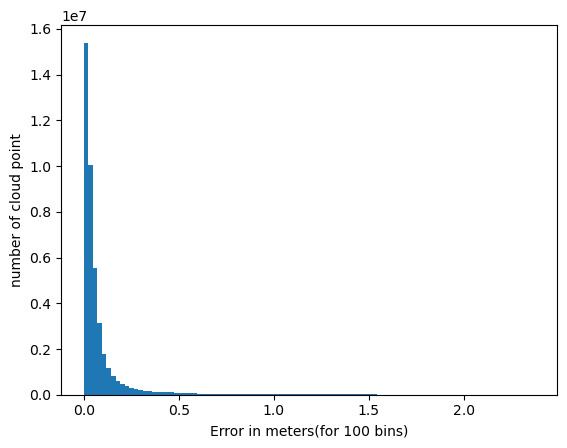

In [11]:
dist_error = dif
error = []
for x in range(len(dist_error)):
    error.append(dist_error[x])
print(len(error))
_ = plt.hist(error, bins=100)
plt.xlabel("Error in meters(for 100 bins)")
plt.ylabel("number of cloud point")
plt.show()

In [12]:
max(error), min(error), sum(error)/len(error), np.log(max(error)),np.log(sum(error)/len(error)) ,np.log(min(error))

(2.374350282965012,
 1.7116513911075912e-05,
 0.08665250062094929,
 0.8647238349934924,
 -2.445849404368503,
 -10.975466834674899)

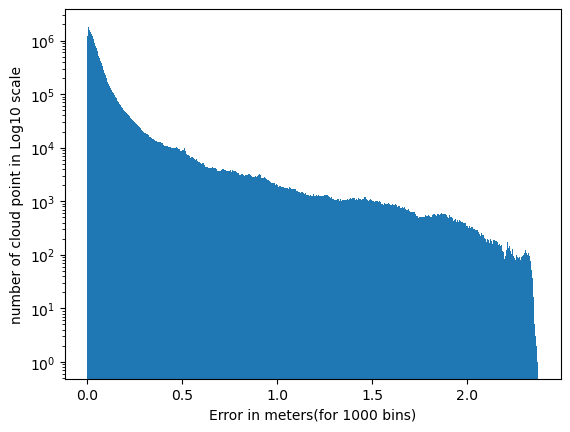

In [16]:
_ = plt.hist(error, bins=1000)
plt.xlabel("Error in meters(for 1000 bins)")
plt.ylabel("number of cloud point in Log10 scale")
plt.yscale("log")
plt.show()

In [17]:
reg

array([[ 0.99922393,  0.02616915, -0.02944003,  0.38621805],
       [-0.02505299,  0.99897638,  0.0376634 ,  1.86568453],
       [ 0.03039551, -0.03689661,  0.99885672, -0.6895438 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [14]:
pcd_14.get_axis_aligned_bounding_box()

AxisAlignedBoundingBox: min: (39.8945, 50.1581, -3.18957), max: (56.909, 66.5956, -0.739254)

In [46]:
1000000*np.log(10)

2302585.092994046

In [ ]:
#
#
#
#
#
#

In [22]:
#
#Alignment using transformation matrix
transformation_mat = registration_icp.transformation
source_array = np.asarray(source.points)
target_array = np.asarray(target.points)
transformation_mat, source_array.shape
source_temp = np.ones([4,len(source_array)], dtype= np.float64)
target_temp = np.ones([4,len(target_array)], dtype= np.float64)
for i in range(len(source_array)):
    source_temp[0:3,i] = source_array[i,:]
for i in range(len(target_array)):
    target_temp[0:3,i] = target_array[i,:]
new_coord = np.matmul(transformation_mat, source_temp)
source_array_transformed = new_coord.T

In [26]:
registration_icp.transformation

array([[ 0.99829971,  0.0541229 ,  0.02164253, -1.86063528],
       [-0.05324219,  0.99780459, -0.03938626,  2.28906878],
       [-0.02372671,  0.03816699,  0.99898965,  0.1951012 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

0.21323697081388926 15.064362021740594


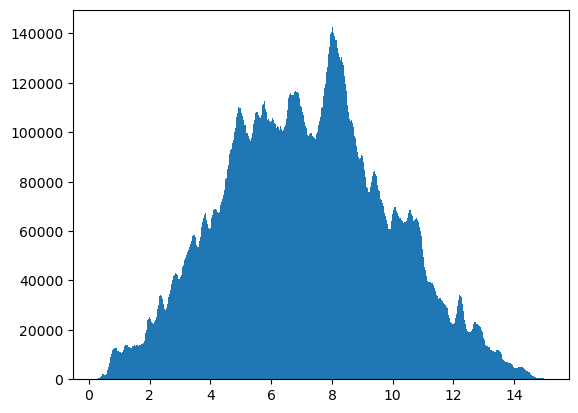

In [26]:
#Error(mean root square over x,y,z axis) after alignment
error = []
for idx in range(len(target_array)):
    er = (target_array[idx,0] - source_array_transformed [idx,0])**2 + (target_array[idx,1] - source_array_transformed[idx,1])**2 + (target_array[idx,2] - source_array_transformed[idx,2])**2
    er = np.sqrt(er)
    error.append(er)
error = np.asarray(error)
#Error Distribution
print(error.min(),error.max())
_ = plt.hist(error, bins='auto')
plt.show()

In [48]:
oct_tree1 = o3d.geometry.Octree(max_depth=8)
oct_tree2 = o3d.geometry.Octree(max_depth=8)
source_array = o3d.geometry.PointCloud()
source_array.points = o3d.utility.Vector3dVector(np.asarray(source_array_transformed))
oct_tree1.convert_from_point_cloud(source_array)
oct_tree2.convert_from_point_cloud(target)



RuntimeError: Unable to cast Python instance to C++ type (compile in debug mode for details)

In [35]:
#Error color mapping and Error visualization
def rgb(minimum, maximum, value):
    minimum, maximum = float(minimum), float(maximum)
    ratio = 2 * (value-minimum) / (maximum - minimum)
    b = int(max(0, 255*(1 - ratio)))
    r = int(max(0, 255*(ratio - 1)))
    g = 255 - b - r
    return r, g, b

color = np.zeros((1000,3))
from time import perf_counter
start = perf_counter()
for idx in range(1000):
    r,g,b = rgb(error.min(), error.max(), error[idx])
    color[idx,0] = r
    color[idx,1] = g
    color[idx,2] = b
end = perf_counter()
print(end-start)
# color = np.zeros((len(source_array_transformed),3))
# for idx in range(len(source_array_transformed)):
#     r,g,b = rgb(error.min(), error.max(), error[idx])
#     color[idx,0] = r
#     color[idx,1] = g
#     color[idx,2] = b
#     print(idx)
# print(color.shape)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(source_array_transformed[:1000,:3])
pcd.colors = o3d.utility.Vector3dVector(color)
o3d.io.write_point_cloud("error.ply", pcd)
pcd_load = o3d.io.read_point_cloud("error.ply")
o3d.visualization.draw_geometries([pcd_load])

25.65067120800086
[Open3D WARNING] Write Ply clamped color value to valid range


KeyboardInterrupt: 

In [50]:
print(source_array.shape,target_array_transformed)